In [2]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [2]:
subprocess.run(
    ['python', 'predict_epi_features/0_predict_epi_feature.py', 
    '-i', 'data/Zhang_MPRA/Zhang_MPRA_final_200bp.csv', 
    '-o', 'predict_epi_features/outputs/Zhang_MPRA_final_200bp_Sei_pred.h5',
    '-m', 'Sei', 
    '-d', 'cuda:0'],
    cwd='..'
)

In [2]:
pred_array = load_h5('outputs/Zhang_MPRA_final_200bp_Sei_pred.h5')
print(pred_array.shape)

# pred_array = load_h5('outputs/Zhang_MPRA_final_Sei_pred.h5')
# print(pred_array.shape)

(17400, 21907)


In [3]:
MPRA_df = pd.read_csv("../data/Zhang_MPRA/Zhang_MPRA_final.csv")
MPRA_df

,seq,id,K562,HepG2,HEK293T,Jurkat
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-2.061,1.465,-0.857,-2.474
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-1.826,-0.830,-1.138,-1.781
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.626,1.967,0.508,1.314
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-1.850,2.512,-0.919,-1.835
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-1.958,0.090,-1.128,-1.847
...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-1.720,2.907,-0.983,-1.588
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-2.389,-1.626,-1.254,-2.107
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-2.233,0.682,-1.148,-2.925
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,-0.790,0.991,-1.126,-2.246


In [2]:
# cell_types = ['K562', 'HEK293T', 'HepG2', 'Jurkat']

cell_types = ['K562', 'HepG2', 'HEK293T', 'Jurkat']
cell_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'HEK293T_Epithelium_Embryonic_Kidney', 'Jurkat_T_Lymphocyte_Blood', 'HEK293_Epithelium_Embryonic_Kidney']

In [3]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [6]:
df = pd.read_csv('../data/Sei/Sei_tracks_info.csv')
# df = df[df['AUROC'] > 0.95]
# df = df[df['AUROC'] > 0.9]
df_pivot = df.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)
df_pivot = df_pivot.map(lambda x: x if isinstance(x, list) else [])
df_pivot.shape

df_track = df_pivot.loc[cell_standard_names, assays]
df_track.map(len)

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
K562_Leukemia_Cell,58,91,51,29
HepG2_Hepatocellular_Carcinoma,9,8,9,17
HEK293T_Epithelium_Embryonic_Kidney,1,10,1,0
Jurkat_T_Lymphocyte_Blood,3,18,9,2
HEK293_Epithelium_Embryonic_Kidney,0,17,5,12


In [7]:
df_track = pd.DataFrame(index=cell_types, columns=assays)
for i in range(len(cell_types)):
    cell_type = cell_types[i]
    cell_standard_name = cell_standard_names[i]
    df_track.loc[cell_type] = df_pivot.loc[cell_standard_name]

df_track.loc['HEK293T'] = df_pivot.loc['HEK293T_Epithelium_Embryonic_Kidney'] + df_pivot.loc['HEK293_Epithelium_Embryonic_Kidney']
df_track.map(len)

,DNase,H3K4me3,H3K27ac,CTCF
K562,58,91,51,29
HepG2,9,8,9,17
HEK293T,1,27,6,12
Jurkat,3,18,9,2


In [8]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_track.loc[cell_type, assay]
        if len(indice) > 0:
            pred = logit(pred_array[:, indice], eps=1e-6).mean(1)
            MPRA_df[f'{cell_type}_{assay}'] = pred
        else:
            MPRA_df[f'{cell_type}_{assay}'] = np.nan

MPRA_df

,seq,id,K562,HepG2,HEK293T,Jurkat,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-2.061,1.465,-0.857,-2.474,-3.111,-6.146,-5.816,-7.040,-1.237,-3.780,-4.959,-5.519,-5.998,-4.734,-5.699,-6.121,-5.763,-7.078,-7.784,-6.907
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-1.826,-0.830,-1.138,-1.781,-6.212,-7.602,-7.796,-8.884,-4.615,-4.875,-5.767,-8.209,-7.159,-6.391,-7.054,-8.796,-6.683,-7.682,-9.228,-8.846
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.626,1.967,0.508,1.314,-2.799,-4.548,-5.240,-5.564,-2.247,-3.026,-4.868,-4.893,-5.976,-4.287,-4.979,-5.087,-3.213,-5.103,-6.045,-5.169
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-1.850,2.512,-0.919,-1.835,-4.785,-7.349,-7.292,-7.466,-5.088,-5.927,-7.531,-6.773,-6.518,-5.772,-6.309,-6.700,-5.474,-7.449,-7.736,-6.735
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-1.958,0.090,-1.128,-1.847,0.077,-5.225,-5.118,-4.054,-1.136,-5.160,-6.164,-3.657,-5.225,-5.352,-5.326,-3.664,-2.389,-6.105,-6.633,-4.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-1.720,2.907,-0.983,-1.588,-2.471,-4.798,-4.993,-6.350,-1.700,-3.620,-4.470,-4.889,-5.061,-3.647,-4.720,-4.985,-4.265,-5.967,-7.209,-6.198
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-2.389,-1.626,-1.254,-2.107,-5.156,-7.778,-7.832,-7.776,-6.663,-7.319,-9.033,-7.888,-6.680,-6.237,-7.078,-7.709,-5.335,-8.052,-8.773,-7.413
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-2.233,0.682,-1.148,-2.925,-6.867,-8.351,-8.505,-9.099,-5.531,-7.079,-8.425,-8.311,-7.971,-7.353,-8.526,-8.586,-7.214,-9.307,-10.826,-8.633
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,-0.790,0.991,-1.126,-2.246,-3.077,-6.771,-6.363,-6.921,-1.759,-5.685,-6.114,-5.442,-5.839,-5.648,-6.401,-6.349,-5.439,-8.303,-9.115,-6.969


In [9]:
for j, assay in enumerate(assays):
    pearson_df = pd.DataFrame()
    for cell_type_0 in cell_types:
        for i, cell_type in enumerate(cell_types):
            pred = MPRA_df[f'{cell_type}_{assay}']
            true = MPRA_df[f'{cell_type_0}']
            r, _ = pearson(pred, true)
            pearson_df.loc[f'{cell_type}_{assay}', f'{cell_type_0}'] = r
    print(pearson_df)

               K562  HepG2  HEK293T  Jurkat
K562_DNase    0.612  0.418    0.510   0.550
HepG2_DNase   0.437  0.526    0.330   0.298
HEK293T_DNase 0.393  0.141    0.308   0.421
Jurkat_DNase  0.445  0.204    0.370   0.552
                 K562  HepG2  HEK293T  Jurkat
K562_H3K4me3    0.561  0.394    0.431   0.528
HepG2_H3K4me3   0.487  0.508    0.364   0.409
HEK293T_H3K4me3 0.230  0.060    0.199   0.352
Jurkat_H3K4me3  0.428  0.192    0.317   0.551
                 K562  HepG2  HEK293T  Jurkat
K562_H3K27ac    0.539  0.391    0.436   0.503
HepG2_H3K27ac   0.390  0.524    0.294   0.277
HEK293T_H3K27ac 0.287  0.185    0.272   0.332
Jurkat_H3K27ac  0.399  0.170    0.295   0.516
              K562  HepG2  HEK293T  Jurkat
K562_CTCF    0.444  0.276    0.289   0.344
HepG2_CTCF   0.397  0.311    0.247   0.275
HEK293T_CTCF 0.431  0.247    0.311   0.373
Jurkat_CTCF  0.461  0.268    0.310   0.413


In [ ]:
# after remove nan, len(x) < 2, pearson = nan
# after remove nan, len(x) < 2, pearson = nan
# after remove nan, len(x) < 2, pearson = nan
# after remove nan, len(x) < 2, pearson = nan
#                K562  HepG2  HEK293T  Jurkat
# K562_DNase    0.612  0.418    0.510   0.550
# HepG2_DNase   0.437  0.526    0.330   0.298
# HEK293T_DNase   NaN    NaN      NaN     NaN
# Jurkat_DNase  0.445  0.204    0.370   0.552
#                  K562  HepG2  HEK293T  Jurkat
# K562_H3K4me3    0.560  0.393    0.430   0.527
# HepG2_H3K4me3   0.487  0.508    0.364   0.409
# HEK293T_H3K4me3 0.211  0.041    0.186   0.340
# Jurkat_H3K4me3  0.428  0.192    0.317   0.551
#                  K562  HepG2  HEK293T  Jurkat
# K562_H3K27ac    0.566  0.427    0.449   0.515
# HepG2_H3K27ac   0.384  0.524    0.291   0.270
# HEK293T_H3K27ac 0.252  0.154    0.245   0.306
# Jurkat_H3K27ac  0.399  0.170    0.295   0.516
#               K562  HepG2  HEK293T  Jurkat
# K562_CTCF    0.444  0.276    0.289   0.344
# HepG2_CTCF   0.397  0.311    0.247   0.275
# HEK293T_CTCF 0.431  0.247    0.311   0.373
# Jurkat_CTCF  0.461  0.268    0.310   0.413

In [10]:
MPRA_df.to_csv('../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_raw.csv', index=False)

In [25]:
MPRA_df = pd.read_csv('../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_raw.csv')
MPRA_df



,seq,id,K562,HepG2,HEK293T,Jurkat,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-2.061,1.465,-0.857,-2.474,-3.111,-6.146,-5.816,-7.040,-1.237,-3.780,-4.959,-5.519,-5.998,-4.734,-5.699,-6.121,-5.763,-7.078,-7.784,-6.907
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-1.826,-0.830,-1.138,-1.781,-6.212,-7.602,-7.796,-8.884,-4.615,-4.875,-5.767,-8.209,-7.159,-6.391,-7.054,-8.796,-6.683,-7.682,-9.228,-8.846
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.626,1.967,0.508,1.314,-2.799,-4.548,-5.240,-5.564,-2.247,-3.026,-4.868,-4.893,-5.976,-4.287,-4.979,-5.087,-3.213,-5.103,-6.045,-5.169
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-1.850,2.512,-0.919,-1.835,-4.785,-7.349,-7.292,-7.466,-5.088,-5.927,-7.531,-6.773,-6.518,-5.772,-6.309,-6.700,-5.474,-7.449,-7.736,-6.735
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-1.958,0.090,-1.128,-1.847,0.077,-5.225,-5.118,-4.054,-1.136,-5.160,-6.164,-3.657,-5.225,-5.352,-5.326,-3.664,-2.389,-6.105,-6.633,-4.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-1.720,2.907,-0.983,-1.588,-2.471,-4.798,-4.993,-6.350,-1.700,-3.620,-4.470,-4.889,-5.061,-3.647,-4.720,-4.985,-4.265,-5.967,-7.209,-6.198
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-2.389,-1.626,-1.254,-2.107,-5.156,-7.778,-7.832,-7.776,-6.663,-7.319,-9.033,-7.888,-6.680,-6.237,-7.078,-7.709,-5.335,-8.052,-8.773,-7.413
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-2.233,0.682,-1.148,-2.925,-6.867,-8.351,-8.505,-9.099,-5.531,-7.079,-8.425,-8.311,-7.971,-7.353,-8.526,-8.586,-7.214,-9.307,-10.826,-8.633
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,-0.790,0.991,-1.126,-2.246,-3.077,-6.771,-6.363,-6.921,-1.759,-5.685,-6.114,-5.442,-5.839,-5.648,-6.401,-6.349,-5.439,-8.303,-9.115,-6.969


In [26]:
pearson_df = pd.DataFrame(dtype=float)
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        pred = MPRA_df[f'{cell_type}_{assay}']
        true = MPRA_df[cell_type]
        r, _ = pearson(pred, true)
        pearson_df.loc[cell_type, assay] = r
print(pearson_df)

         DNase  H3K4me3  H3K27ac  CTCF
K562     0.612    0.561    0.539 0.444
HepG2    0.526    0.508    0.524 0.311
HEK293T  0.308    0.199    0.272 0.311
Jurkat   0.552    0.551    0.516 0.413


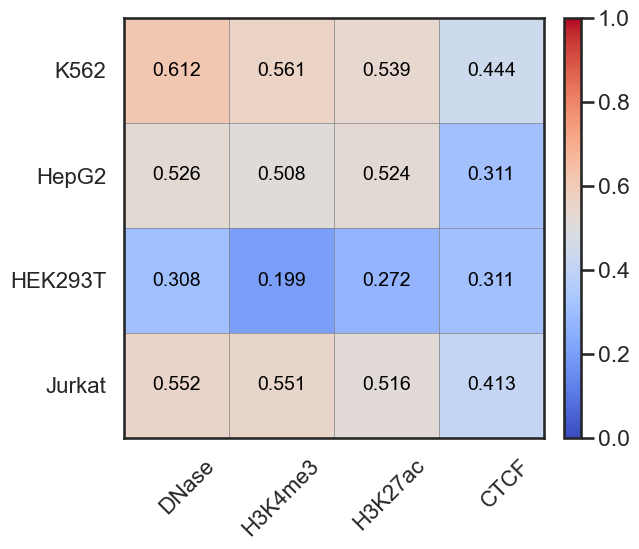

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style("white")

corr_df = pearson_df

# 提取数据
data = corr_df.values
row_labels = corr_df.index.tolist()
col_labels = corr_df.columns.tolist()

# 创建画布和坐标轴
fig, ax = plt.subplots(figsize=(9, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

# 绘制热图
im = ax.imshow(data, cmap='coolwarm', vmin=0.0, vmax=1.0)

# 设置 divider 来控制 colorbar 的轴
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.2)  # size 为 colorbar 宽度，pad 为间距

# 添加 colorbar
cbar = fig.colorbar(im, cax=cax)

# 添加文本注释（跳过 NaN）
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=14)

# 设置坐标轴标签
ax.set_xticks(np.arange(len(col_labels))+0.4)
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=16)
ax.set_yticklabels(row_labels, fontsize=16)

# 设置灰色网格线
ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
ax.grid(which='minor', color='gray', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # 自动布局和保存
# plt.tight_layout()
plt.savefig('figures/Zhang_MPRA_Sei_correlation_heatmap.png', dpi=400)

In [4]:
Gosai_MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_Sei_feature_0529.csv')
Gosai_Sei_pred_array = load_h5('outputs/Gosai_MPRA_Sei_pred.h5')
print(Gosai_MPRA_df.shape)
print(Gosai_Sei_pred_array.shape)

(760679, 54)
(760679, 21907)


In [8]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_track.loc[cell_type, assay]
        if len(indice) > 0:
            pred = logit(Gosai_Sei_pred_array[:, indice], eps=1e-6).mean(1)
            Gosai_MPRA_df[f'{cell_type}_{assay}'] = pred
        else:
            Gosai_MPRA_df[f'{cell_type}_{assay}'] = np.nan

Gosai_MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,-3.716,-5.486,-6.218,-7.278,-5.233,-8.731,-2.985,-5.719,-4.818,-4.984,-6.990,-3.876,-6.347,-7.907,NaN,-5.720,-4.297,-5.065,-6.959,-3.039,NaN,-7.790,NaN,-6.087,-4.122,-4.643,-5.941,-5.479,-5.439,-7.598,NaN,-5.599,-3.500,-4.236,-5.951,NaN,-6.587,NaN,-7.099,-5.150,-5.938,-4.777,-4.794,-5.805,-5.263,-6.196,-7.387,-6.106
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,-3.674,-5.432,-6.220,-7.250,-5.224,-8.707,-2.924,-5.765,-4.805,-4.937,-6.985,-3.891,-6.413,-7.923,NaN,-5.793,-4.170,-4.906,-6.837,-3.041,NaN,-7.814,NaN,-6.098,-4.111,-4.585,-5.896,-5.394,-5.372,-7.561,NaN,-5.651,-3.491,-4.125,-5.871,NaN,-6.552,NaN,-7.057,-5.198,-5.936,-4.678,-4.736,-5.820,-5.199,-6.129,-7.395,-6.112
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,-5.582,-8.174,-8.323,-8.338,-7.815,-10.701,-6.840,-8.355,-4.805,-6.109,-7.778,-6.314,-5.830,-10.344,NaN,-7.261,-6.681,-6.365,-6.456,-6.016,NaN,-9.288,NaN,-7.791,-3.584,-6.708,-6.793,-6.096,-5.219,-10.393,NaN,-7.252,-2.482,-5.822,-7.466,NaN,-6.673,NaN,-9.750,-7.006,-6.450,-6.403,-7.152,-7.193,-6.581,-8.874,-9.804,-7.999
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,-5.368,-7.869,-8.103,-8.168,-7.640,-10.673,-6.845,-8.255,-4.791,-5.761,-7.562,-6.196,-5.684,-10.297,NaN,-7.263,-6.351,-5.831,-5.892,-6.031,NaN,-9.298,NaN,-7.564,-3.601,-6.489,-6.609,-5.966,-5.112,-10.508,NaN,-7.210,-2.437,-5.375,-7.054,NaN,-6.412,NaN,-9.720,-6.954,-6.169,-6.034,-6.933,-7.072,-6.534,-8.612,-9.581,-7.877
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,-8.170,-10.336,-9.104,-9.135,-9.694,-12.692,-8.637,-10.799,-9.580,-9.698,-10.645,-7.371,-9.600,-11.485,NaN,-11.242,-8.547,-9.190,-9.197,-7.587,NaN,-12.028,NaN,-11.238,-8.025,-9.397,-9.246,-7.205,-8.969,-12.176,NaN,-9.806,-7.934,-9.507,-10.218,NaN,-9.958,NaN,-11.013,-10.371,-7.950,-8.541,-9.246,-9.996,-8.181,-10.310,-9.737,-9.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,-1.869,-4.299,-6.037,-6.614,-4.801,-7.704,-1.766,-5.451,-2.745,-3.408,-6.564,-4.101,-5.933,-7.847,NaN,-5.345,-0.324,-2.255,-5.013,-2.527,NaN,-8.024,NaN,-3.944,-1.485,-2.670,-4.878,-4.243,-4.165,-6.672,NaN,-5.477,-0.867,-2.169,-3.957,NaN,-5.455,NaN,-6.570,-4.570,-5.391,-3.677,-4.137,-4.742,0.337,-3.193,-4.951,-3.552
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-7.272,-10.141,-9.020,-9.353,-9.003,-11.804,-8.000,-10.233,-8.482,-9.988,-10.444,-7.432,-8.972,-10.877,NaN,-10.184,-5.639,-9.002,-9.5

In [10]:
MPRA_df = pd.read_csv('../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_raw.csv')
MPRA_df

,seq,id,K562,HepG2,HEK293T,Jurkat,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-2.061,1.465,-0.857,-2.474,-3.111,-6.146,-5.816,-7.040,-1.237,-3.780,-4.959,-5.519,-5.998,-4.734,-5.699,-6.121,-5.763,-7.078,-7.784,-6.907
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-1.826,-0.830,-1.138,-1.781,-6.212,-7.602,-7.796,-8.884,-4.615,-4.875,-5.767,-8.209,-7.159,-6.391,-7.054,-8.796,-6.683,-7.682,-9.228,-8.846
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.626,1.967,0.508,1.314,-2.799,-4.548,-5.240,-5.564,-2.247,-3.026,-4.868,-4.893,-5.976,-4.287,-4.979,-5.087,-3.213,-5.103,-6.045,-5.169
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-1.850,2.512,-0.919,-1.835,-4.785,-7.349,-7.292,-7.466,-5.088,-5.927,-7.531,-6.773,-6.518,-5.772,-6.309,-6.700,-5.474,-7.449,-7.736,-6.735
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-1.958,0.090,-1.128,-1.847,0.077,-5.225,-5.118,-4.054,-1.136,-5.160,-6.164,-3.657,-5.225,-5.352,-5.326,-3.664,-2.389,-6.105,-6.633,-4.562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-1.720,2.907,-0.983,-1.588,-2.471,-4.798,-4.993,-6.350,-1.700,-3.620,-4.470,-4.889,-5.061,-3.647,-4.720,-4.985,-4.265,-5.967,-7.209,-6.198
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-2.389,-1.626,-1.254,-2.107,-5.156,-7.778,-7.832,-7.776,-6.663,-7.319,-9.033,-7.888,-6.680,-6.237,-7.078,-7.709,-5.335,-8.052,-8.773,-7.413
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-2.233,0.682,-1.148,-2.925,-6.867,-8.351,-8.505,-9.099,-5.531,-7.079,-8.425,-8.311,-7.971,-7.353,-8.526,-8.586,-7.214,-9.307,-10.826,-8.633
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,-0.790,0.991,-1.126,-2.246,-3.077,-6.771,-6.363,-6.921,-1.759,-5.685,-6.114,-5.442,-5.839,-5.648,-6.401,-6.349,-5.439,-8.303,-9.115,-6.969


In [11]:
for cell_type in cell_types:
    for assay in assays:
        x = MPRA_df[f'{cell_type}_{assay}'].copy()
        if f'{cell_type}_{assay}' in Gosai_MPRA_df.columns:
            x_mean = Gosai_MPRA_df[f'{cell_type}_{assay}'].mean()
            x_std = Gosai_MPRA_df[f'{cell_type}_{assay}'].std()
            print(f'{cell_type}_{assay}', 'Gosai', x_mean, x_std)
        else:
            x_mean = x.mean()
            x_std = x.std()
            print(f'{cell_type}_{assay}', 'Gosai not have')
        x = (x - x_mean) / x_std
        MPRA_df[f'{cell_type}_{assay}'] = x

MPRA_df

K562_DNase Gosai -6.431374580499929 1.9383600995383612
K562_H3K4me3 Gosai -8.974331102557876 1.6658674826105078
K562_H3K27ac Gosai -8.38484266627645 1.1504697907940835
K562_CTCF Gosai -8.85550691885461 1.9804421535000811
HepG2_DNase Gosai -7.477907549610169 2.1404724738472387
HepG2_H3K4me3 Gosai -8.455899544165293 1.8617207357455898
HepG2_H3K27ac Gosai -9.440372904130538 1.5078894201813222
HepG2_CTCF Gosai -8.721059763641227 2.227371116442315
HEK293T_DNase Gosai -7.215856757035813 0.8353301613058033
HEK293T_H3K4me3 Gosai -7.566704058020669 1.3845373670196404
HEK293T_H3K27ac Gosai -7.684127837638846 1.5566395079244315
HEK293T_CTCF Gosai -8.272245416529001 1.755403127316019
Jurkat_DNase Gosai -6.515284934615988 2.0681134348192693
Jurkat_H3K4me3 Gosai -9.257849471824136 1.727328619269921
Jurkat_H3K27ac Gosai -9.353150262147778 1.5846100957611653
Jurkat_CTCF Gosai -8.019842769679137 1.7221448719656305


,seq,id,K562,HepG2,HEK293T,Jurkat,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-2.061,1.465,-0.857,-2.474,1.713,1.698,2.233,0.917,2.916,2.512,2.972,1.438,1.458,2.046,1.275,1.226,0.364,1.262,0.990,0.646
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-1.826,-0.830,-1.138,-1.781,0.113,0.824,0.512,-0.014,1.338,1.924,2.436,0.230,0.068,0.849,0.405,-0.298,-0.081,0.912,0.079,-0.480
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.626,1.967,0.508,1.314,1.874,2.657,2.733,1.662,2.444,2.917,3.032,1.719,1.485,2.369,1.738,1.815,1.597,2.405,2.088,1.655
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-1.850,2.512,-0.919,-1.835,0.849,0.975,0.950,0.702,1.117,1.359,1.266,0.875,0.835,1.296,0.884,0.896,0.504,1.047,1.020,0.746
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-1.958,0.090,-1.128,-1.847,3.357,2.251,2.840,2.425,2.963,1.770,2.173,2.273,2.383,1.600,1.515,2.625,1.995,1.825,1.716,2.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-1.720,2.907,-0.983,-1.588,2.043,2.507,2.948,1.265,2.700,2.598,3.296,1.720,2.579,2.831,1.904,1.873,1.088,1.905,1.353,1.058
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-2.389,-1.626,-1.254,-2.107,0.658,0.718,0.481,0.545,0.381,0.611,0.270,0.374,0.641,0.960,0.390,0.321,0.571,0.698,0.366,0.352
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-2.233,0.682,-1.148,-2.925,-0.225,0.374,-0.104,-0.123,0.909,0.740,0.673,0.184,-0.904,0.154,-0.541,-0.179,-0.338,-0.029,-0.929,-0.356
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,-0.790,0.991,-1.126,-2.246,1.730,1.323,1.758,0.977,2.672,1.488,2.206,1.472,1.649,1.385,0.825,1.096,0.520,0.553,0.150,0.610


In [12]:
print(MPRA_df.drop(columns=['seq', 'id']).mean())

K562              -1.515
HepG2             -0.995
HEK293T           -0.723
Jurkat            -0.968
K562_DNase         1.668
K562_H3K4me3       1.406
K562_H3K27ac       1.411
K562_CTCF          1.290
HepG2_DNase        0.974
HepG2_H3K4me3      1.136
HepG2_H3K27ac      0.777
HepG2_CTCF         1.083
HEK293T_DNase      1.785
HEK293T_H3K4me3    1.851
HEK293T_H3K27ac    1.000
HEK293T_CTCF       1.546
Jurkat_DNase       2.059
Jurkat_H3K4me3     1.948
Jurkat_H3K27ac     1.602
Jurkat_CTCF        1.600
dtype: float64


In [13]:
MPRA_df.to_csv('../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_zscore_Gosai_ref.csv', index=False)

In [12]:
cols = cell_types + [f'{cell_type}_{assay}' for cell_type in cell_types for assay in assays]

x = MPRA_df[cols].copy()
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)
x = (x - x_mean) / x_std

MPRA_df[cols] = x
MPRA_df

,seq,id,K562,HepG2,HEK293T,Jurkat,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_CTCF,Jurkat_DNase,Jurkat_H3K4me3,Jurkat_H3K27ac,Jurkat_CTCF
0,AAAAAAAAAAACCTCTGCCTTCATTGCAAATTCTTGGTGGTATGAA...,chr10:61837316-61837484,-0.325,2.187,-0.159,-1.084,0.048,0.380,0.873,-0.283,2.048,1.585,2.216,0.277,-0.275,0.233,0.408,-0.254,-1.616,-0.792,-0.666,-0.615
1,AAAAAAAACAAAACAGGTAAGGATGAAAAGTTCCAGGTGAGAACAA...,chr12:45192846-45193014,-0.185,0.146,-0.491,-0.586,-1.655,-0.760,-0.955,-0.989,0.384,0.907,1.675,-0.668,-1.446,-1.196,-0.881,-1.467,-2.040,-1.196,-1.660,-1.341
2,AAAAAAAGCACAAAAATGCAAAAAACGTAGCACAGCAAAAAGGACA...,chr13:50241636-50241804,1.867,2.633,1.457,1.643,0.219,1.630,1.404,0.282,1.550,2.051,2.277,0.497,-0.253,0.618,1.093,0.214,-0.441,0.529,0.530,0.036
3,AAAAAAAGCATGGAGTTAGGAAAAATTTTCCTATGGGAGTGAGGTA...,chrX:102658676-102658844,-0.199,3.117,-0.232,-0.625,-0.871,-0.562,-0.489,-0.446,0.150,0.256,0.494,-0.163,-0.800,-0.663,-0.172,-0.517,-1.483,-1.040,-0.634,-0.551
4,AAAAACACTTGAAAATTTTTGGCAGTCAGCAGGAATAGATAGGGAG...,chr7:79506606-79506774,-0.263,0.964,-0.479,-0.633,1.799,1.100,1.517,0.861,2.098,0.731,1.409,0.931,0.504,-0.301,0.763,0.859,-0.061,-0.142,0.125,0.263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,TTTTTTCCCCTTTCCCTCCTCAGGTCTTCCTGTCAGCTGTTACTAT...,chr18:39701966-39702134,-0.122,3.469,-0.308,-0.447,0.400,1.435,1.632,-0.019,1.820,1.684,2.543,0.498,0.668,1.170,1.339,0.260,-0.926,-0.049,-0.271,-0.350
17396,TTTTTTCTAATTGTTTTAGAGGTTGAAAGATACTGTGACTCTTCCG...,orig_backbone_change20%_18,-0.519,-0.561,-0.629,-0.821,-1.075,-0.897,-0.988,-0.564,-0.626,-0.605,-0.512,-0.555,-0.963,-1.064,-0.903,-0.974,-1.419,-1.443,-1.347,-0.805
17397,TTTTTTGTTGCTGTTCTGTTTTACCTTTCACCATGGAAAATTTGGT...,chr2:64128946-64129114,-0.427,1.491,-0.503,-1.409,-2.014,-1.345,-1.609,-1.071,-0.068,-0.457,-0.105,-0.704,-2.264,-2.026,-2.281,-1.371,-2.285,-2.283,-2.760,-1.261
17398,TTTTTTTCAGCTCACTTTTCCCTTGACTTCTAAAGCACATATTTAC...,chr5:99721596-99721764,0.431,1.765,-0.476,-0.921,0.067,-0.109,0.368,-0.237,1.791,0.405,1.443,0.304,-0.115,-0.556,-0.259,-0.358,-1.466,-1.612,-1.582,-0.638


In [13]:
MPRA_df.to_csv('../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_zscore.csv', index=False)